In [1]:
import numpy as np
import numpy.polynomial as P
import scipy as sp
from matplotlib import pyplot as plt
from tqdm import tqdm
#from sklearn.preprocessing import PolynomialFeatures
from multiprocessing import Pool
import multiprocessing
import ZVnbrosse
from sklearn.preprocessing import PolynomialFeatures
from potentials import GaussPotential,GaussMixture,GausMixtureIdent,GausMixtureSame,BananaShape
from samplers import MCMC_sampler,Generate_train,ULA_light
from baselines import set_function,construct_ESVM_kernel,GenerateSigma
from martingale import approx_q
from optimize import Run_eval_test,optimize_parallel_new 
from utils import * 
import copy

In [2]:
a = np.arange(10)
b = np.roll(a,2)
c = np.roll(a,-1)
print(c)

[1 2 3 4 5 6 7 8 9 0]


In [3]:
a = np.array([[1, 2], [3, 4]])
print(a.shape)
b = np.array([[5, 6]])
print(b.shape)
c = np.concatenate((a,b),axis=0)
print(c.shape)

(2, 2)
(1, 2)
(3, 2)


In [4]:
x = np.array([[1,2,3],[1,2,3]])
print(x.shape)
poly = PolynomialFeatures(2)
features = poly.fit_transform(x)
print(features)


(2, 3)
[[1. 1. 2. 3. 1. 2. 3. 4. 6. 9.]
 [1. 1. 2. 3. 1. 2. 3. 4. 6. 9.]]


In [5]:
def H(k, x):
    if k==0:
        return 1.0
    if k ==1:
        return x
    if k==2:
        return (x**2 - 1)/np.sqrt(2)
    c = np.zeros(k+1,dtype = float)
    c[k] = 1.0
    h = P.hermite_e.hermeval(x,c) / np.sqrt(sp.special.factorial(k)) 
    return h

def compute_H(k,x,d):
    cur_prod = 1.0
    for i in range(d):
        cur_prod = cur_prod*H(k[i],x[:,i])
    return cur_prod

In [6]:
def generate_lexicographical_2nd_order(d):
    """
    function to generate lexigoraphical polynomials of 1st and 2nd order
    """
    cur_list = []
    for i in range(d):
        cur_permute = np.zeros(d,dtype = int)
        cur_permute[i] = 1
        cur_list.append(np.copy(cur_permute))
        cur_permute[i] = 0
    for i in range(d):
        cur_permute = np.zeros(d,dtype = int)
        cur_permute[i] = 2
        cur_list.append(np.copy(cur_permute))
        cur_permute[i] = 1
        for j in range(i+1,d):
            cur_permute[j] = 1
            cur_list.append(np.copy(cur_permute))
            cur_permute[j] = 0
    return cur_list

a = generate_lexicographical_2nd_order(3)
print(a)

[array([1, 0, 0]), array([0, 1, 0]), array([0, 0, 1]), array([2, 0, 0]), array([1, 1, 0]), array([1, 0, 1]), array([0, 2, 0]), array([0, 1, 1]), array([0, 0, 2])]


In [7]:
c = np.array([1,2,3,4,5])
c = c.reshape((1,5))
print(c.shape)

(1, 5)


In [8]:
def test_traj(coefs_poly_regr,gamma,r_seed,lag,d,N_test,x0):
    """
    function to perform 1-dimensional martingale decomposition
    """
    X_test,Noise = generate_traj(x0,N_test,gamma,r_seed,d)
    test_stat_vanilla = np.zeros(N_test,dtype = float)
    test_stat_vr = np.zeros_like(test_stat_vanilla)
    #compute number of basis polynomials
    basis_funcs = generate_lexicographical_2nd_order(d)
    num_basis_funcs = len(basis_funcs)
    #compute polynomials of noise variables Z_l
    poly_vals = np.zeros((num_basis_funcs,N_test), dtype = float)
    for k in range(len(basis_funcs)):
        poly_vals[k,:] = compute_H(basis_funcs[k],Noise,d)
    #initialize function
    f_vals_vanilla = np.sum(X_test**2,axis=1)
    #array to store control variates values
    cvfs = np.zeros_like(f_vals_vanilla)
    #compute coeffitients bar_a
    bar_a_1st_order = np.zeros((lag,d,N_test),dtype=float)
    bar_a_2nd_order = np.zeros((lag,d,d,N_test),dtype=float)
    #preprocessing 
    X_test = np.concatenate((x0.reshape(1,d),X_test),axis=0)
    coefs_poly_1st_order = np.zeros((lag,d),dtype=float)
    coefs_poly_1st_order = coefs_poly_regr[:,1:d+1]
    coefs_poly_2nd_order = np.zeros((lag,d,d),dtype=float)
    counter = 0
    for i in range(d):
        for j in range(i,d):
            coefs_poly_2nd_order[:,i,j] = coefs_poly_regr[:,d+1+counter]
            counter += 1
    for i in range(lag):
        #first-order coefficients
        for j in range(d):
            bar_a_1st_order[i,j,:] = coefs_poly_1st_order[i,j]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]
            #sum more coefficients
            for k in range(j):
                bar_a_1st_order[i,j,:] += coefs_poly_2nd_order[i,k,j]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]*((X_test[:-1]+gamma*b(X_test[:-1]))[:,k])
            #diagonal part
            bar_a_1st_order[i,j] += 2*coefs_poly_2nd_order[i,j,j]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]*((X_test[:-1]+gamma*b(X_test[:-1]))[:,j])
            #sum more coefficients
            for k in range(j+1,d):
                bar_a_1st_order[i,j] += coefs_poly_2nd_order[i,j,k]*np.sqrt(gamma)*sigma(X_test[:-1])[:,j]*((X_test[:-1]+gamma*b(X_test[:-1]))[:,k])
            #second-order coefficients, to be filled
            bar_a_2nd_order[i,j,j,:] = coefs_poly_2nd_order[i,j,j]*np.sqrt(2)*gamma*sigma(X_test[:-1])[:,j]  
        """
        bar_a_0_1[i,1:] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_0_1[i,0] = coefs_poly_regr[i,1]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[1,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,1])+\
                        2*coefs_poly_regr[i,5]*cov[1,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #coefficients with H_1_0
        bar_a_1_0[i,1:] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(X_test[:-1])[:,0]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,0]+\
                        coefs_poly_regr[i,4]*(((X_test[:-1]+gamma*b(X_test[:-1]))[:,0])*sigma(X_test[:-1])[:,1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((X_test[:-1]+gamma*b(X_test[:-1]))[:,1])*sigma(X_test[:-1])[:,0]*np.sqrt(gamma)*cov[0,0])+\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(X_test[:-1])[:,1]*(X_test[:-1]+gamma*b(X_test[:-1]))[:,1]
        bar_a_1_0[i,0] = coefs_poly_regr[i,1]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]+\
                        coefs_poly_regr[i,2]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]+\
                        2*coefs_poly_regr[i,3]*cov[0,0]*np.sqrt(gamma)*sigma(x0)[0]*(x0+gamma*b(x0))[0]+\
                        coefs_poly_regr[i,4]*(((x0+gamma*b(x0))[0])*sigma(x0)[1]*np.sqrt(gamma)*cov[0,1] +\
                                             ((x0+gamma*b(x0))[1])*sigma(x0)[0]*np.sqrt(gamma)*cov[0,0]) +\
                        2*coefs_poly_regr[i,5]*cov[0,1]*np.sqrt(gamma)*sigma(x0)[1]*(x0+gamma*b(x0))[1]
        #second-order coefficients
        bar_a_1_1[i,1:] = 2*coefs_poly_regr[i,3]*gamma*(sigma(X_test[:-1])[:,0])**2*cov[0,0]*cov[0,1]+\
                        coefs_poly_regr[i,4]*gamma*(sigma(X_test[:-1])[:,0])*(sigma(X_test[:-1])[:,1])*(cov[0,1]**2 + cov[0,0]*cov[1,1])+\
                        2*coefs_poly_regr[i,5]*gamma*(sigma(X_test[:-1])[:,1])**2*cov[1,1]*cov[0,1]
        bar_a_1_1[i,0] = 2*coefs_poly_regr[i,3]*gamma*(sigma(x0)[0])**2*cov[0,0]*cov[0,1]+\
                        coefs_poly_regr[i,4]*gamma*(sigma(x0)[0])*(sigma(x0)[1])*(cov[0,1]**2 + cov[0,0]*cov[1,1])+\
                        2*coefs_poly_regr[i,5]*gamma*(sigma(x0)[1])**2*cov[1,1]*cov[0,1]
        #coefficients with H_2_0
        bar_a_2_0[i,1:] = np.sqrt(2)*coefs_poly_regr[i,3]*gamma
        #coefficients with H_0_2
        bar_a_0_2[i,1:] = np.sqrt(2)*coefs_poly_regr[i,5]*gamma
        """
    #bar_a_1_0 = bar_a_1_0*poly_vals[0,:]
    #bar_a_0_1 = bar_a_0_1*poly_vals[1,:]
    #bar_a_1_1 = bar_a_1_1*poly_vals[2,:]
    #bar_a_2_0 = bar_a_2_0*poly_vals[3,:]
    #bar_a_0_2 = bar_a_0_2*poly_vals[4,:]
    for i in range(d):
        bar_a_1st_order[:,i,:] = poly_vals[i,:]*bar_a_1st_order[:,i,:]
        bar_a_2nd_order[:,i,i,:] = poly_vals[d + d*(d+1)//2 - (d-i)*(d-i+1)//2,:]*bar_a_2nd_order[:,i,i,:] 
    #compute martingale sums
    M_n_1st = 0.0
    M_n_2nd = 0.0
    for l in range(N_test):
        for r in range(min(N_test-l,lag)):
            M_n_1st += np.sum(bar_a_1st_order[r,:,l])
            axis=tuple(range(arr.ndim - 1))
    return np.mean(f_vals_vanilla), np.mean(f_vals_vanilla)-(M_n_1st)/N_test, np.mean(f_vals_vanilla)-(M_n_1st+M_n_2nd)/N_test
#
#
#

In [9]:
def approx_q(X_train,Y_train,N_traj_train,lag,max_deg):
    """
    Function to regress q functions on a polynomial basis;
    Args:
        X_train - train tralectory;
        Y_train - function values;
        N_traj_train - number of training trajectories;
        lag - truncation point for coefficients, those for |p-l| > lag are set to 0;
        max_deg - maximum degree of polynomial in regression
    """
    dim = X_train[0,:].shape[0]
    #print("dimension = ",dim)
    coefs_poly = np.array([])
    for i in range(lag):
        x_all = np.array([])
        y_all = np.array([])
        for j in range(N_traj_train):
            y = Y_train[j,i:,0]
            if i == 0:
                x = X_train[j,:]
            else:
                x = X_train[j,:-i]
            #concatenate results
            if x_all.size == 0:
                x_all = x
            else:
                x_all = np.concatenate((x_all,x),axis = 0)
            y_all = np.concatenate([y_all,y])
        #should use polyfeatures here
        #print("variance: ",np.var(y_all))
        #print(y_all[:50])
        poly = PolynomialFeatures(max_deg)
        X_features = poly.fit_transform(x_all)
        #print(X_features.shape)
        lstsq_results = np.linalg.lstsq(X_features,y_all,rcond = None)
        coefs = copy.deepcopy(lstsq_results[0])
        coefs.resize((1,X_features.shape[1]))           
        if coefs_poly.size == 0:
            coefs_poly = copy.deepcopy(coefs)
        else:
            coefs_poly = np.concatenate((coefs_poly,coefs),axis=0)
    return coefs_poly

In [10]:
a = 0.5
sig = 1.0

def b(X_t):
    """
    b function in the diffusion
    """
    #return a*(c-X_t)
    if len(X_t.shape) == 1:
        sin_part = np.sin(X_t)
        return -(X_t + a*np.roll(sin_part,-1))
    else:
        sin_part = np.sin(X_t)
        return -(X_t + a*np.roll(sin_part,-1,axis=1))

def sigma(X_t):
    """
    b function in the diffusion
    """
    return sig*np.ones_like(X_t)

def sample_discretized_diffusion(X_t,gamma_t,d):
    """
    args:   X_t - current value, 
            gamma_t - step size;
            d - dimension;
            cov - covariance matrix
    returns:  (X_{t+1},xi_{t+1}) - value at the next time moment and the corresponding noise variable
    """
    xi = np.random.randn(d)
    return X_t + gamma_t*b(X_t) + np.sqrt(gamma_t)*sigma(X_t)*xi,xi

#currently we use this function without the burn-in
def generate_traj(x0,n,gamma,r_seed,d):
    """
    args:
        x0 - starting point;
        n - number of steps;
        gamma - step size (assumed to be fixed for now);
    returns:
        x_all,noise_all - np.arrays of shape (n,)  
    """
    x_all = np.zeros((n,d),dtype = float)
    noise_all = np.zeros((n,d),dtype = float)
    np.random.seed(r_seed)
    x_all[0],noise_all[0] = sample_discretized_diffusion(x0,gamma,d)
    for i in range(1,n):
        x_all[i],noise_all[i] = sample_discretized_diffusion(x_all[i-1],gamma,d)
    return x_all,noise_all

def run_monte_carlo(x,f_type):
    if f_type == "quadratic":
        f_vals = x**2
    else:
        raise "not implemented error"
    return np.mean(f_vals,axis=1)

In [11]:
n = 5*10**3 #sample size
gamma = 1e-1 # Step size
n_traj = 1
d = 5
n_traj_test = 100 # Number of independent MCMC trajectories for test
f_type = "quadratic"
K_max = 2 #max degree of Hermite polynomial
S_max = 2 #max degree of polynomial during regression stage
lag = 20 #maximal lag order
N_test = 5*10**3

Sample discretized diffusion

In [12]:
def generate_observations(x0,n,gamma,r_seed,d):
    X_train, noise_train = generate_traj(x0,n,gamma,r_seed,d)
    #set target function
    Y_train = np.sum(X_train**2,axis=1)
    X_train = X_train.reshape((1,-1,d))
    Y_train = Y_train.reshape((1,-1,1))
    return X_train, noise_train, Y_train

In [13]:
x0 = np.ones(d,dtype = float)
r_seed = 1812
X_train, noise_train, Y_train = generate_observations(x0,n,gamma,r_seed,d)

### Bernoulli:: Optimize coefficients by solving regression with polynomial features

In [14]:
#polynomial coefficients
coefs_poly = approx_q(X_train,Y_train,n_traj,lag,S_max)
#print(coefs_poly.shape)
print(coefs_poly)
regr_vals = np.zeros((lag,X_train.shape[1]),dtype=float)
poly = PolynomialFeatures(S_max)
features = poly.fit_transform(X_train[0])
#features = np.zeros((X_train.shape[1],6),dtype=float)
#features[:,0] = 1.0
#features[:,1:3] = X_train[0,:,:]
#features[:,3] = X_train[0,:,0]**2 
#features[:,4] = X_train[0,:,0]*X_train[0,:,1]
#features[:,5] = X_train[0,:,1]**2
for i in range(len(regr_vals)):
    regr_vals[i,:] = np.sum(coefs_poly[i,:]*features,axis=1)

[[-1.37878573e-15  1.33226763e-15  2.06892683e-16  1.47653995e-16
  -2.27366850e-16  1.16637143e-16  1.00000000e+00 -1.30859141e-15
   4.78642880e-16  3.45050052e-16  6.82515270e-17  1.00000000e+00
   1.43692732e-16  8.07090419e-16 -1.27697358e-16  1.00000000e+00
  -7.09047214e-16 -5.94142791e-17  1.00000000e+00 -2.77555756e-17
   1.00000000e+00]
 [ 4.81697296e-01 -2.24773385e-02 -1.69334961e-02  1.89349578e-02
  -3.71131237e-03  5.40388150e-03  7.68673210e-01 -1.48207906e-01
  -1.31218941e-02  4.34353096e-02 -5.04699848e-02  8.08052950e-01
  -3.35146478e-02  3.33609079e-02 -5.30093735e-02  8.75434470e-01
  -3.57707829e-02  4.63304941e-02  8.30979244e-01 -1.40392342e-02
   8.26206265e-01]
 [ 8.95688366e-01 -4.77112889e-02 -7.69861454e-03  5.45897414e-02
  -8.46842528e-04  8.95675312e-03  5.99112599e-01 -2.65259690e-01
   9.70935643e-03  6.45168780e-02 -7.64143470e-02  6.44822636e-01
  -3.86836203e-02  3.42923735e-02 -1.06749783e-01  7.56261934e-01
  -9.18181518e-02  5.93923588e-02  6.7

Test our regressors

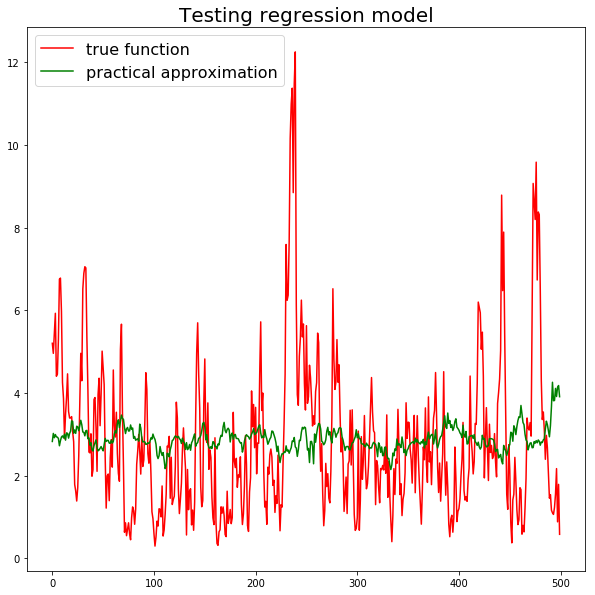

In [15]:
cur_lag = 19
N_pts = 500
plt.figure(figsize=(10, 10))
plt.title("Testing regression model",fontsize=20)
plt.plot(Y_train[0,cur_lag:N_pts+cur_lag,0],color='r',label='true function')
plt.plot(regr_vals[cur_lag,:N_pts],color='g',label = 'practical approximation')
plt.legend(loc = 'upper left',fontsize = 16)
plt.show()

In [16]:
test_seed = 1453
nbcores = multiprocessing.cpu_count()
trav = Pool(nbcores)
res = trav.starmap(test_traj, [(coefs_poly,gamma,test_seed+i,lag,d,N_test,x0) for i in range (n_traj_test)])
#res = trav.starmap(test_traj, [(Cur_pot,coefs_poly,step,test_seed+i,lag,K_max,S_max,N_burn,N_test,d,f_type,inds_arr,params,x0,fixed_start) for i in range (n_traj_test)])
trav.close()
res = np.asarray(res)
print(res.shape)

(24, 3)


### Comparison plots

In [19]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']#,'Euler scheme \nwith MDCV-2']

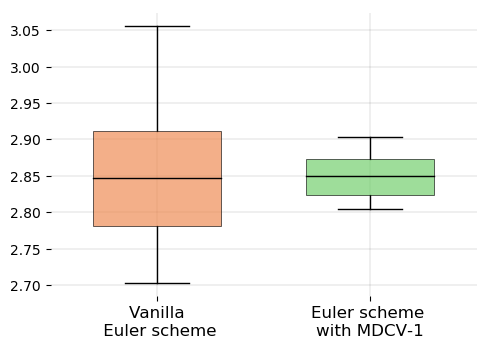

In [20]:
data = [res[:,0],res[:,1]]#, res_new_0[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_quadratic_lag_20_d_5.pdf")

In [ ]:
def set_axis_style_boxplot(ax, labels, parts):
    colors = (sns.color_palette("muted")[0:7])
    ax.grid(color='black', linestyle='-', linewidth=0.15, alpha=0.6)    
    ax.set_xticks(np.arange(1, len(labels)+1))
    ax.set_xticklabels(labels, fontsize=12)
    ax.set_xlim(0.5, len(labels) + 0.5)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["right"].set_visible(False)
    
    for pc,i in zip(parts['boxes'],range(len(labels))):
        pc.set(facecolor=colors[i],alpha=0.65)
        pc.set_edgecolor('black')
        pc.set_linewidth(0.65)
    

def boxplot_ind(data, title, labels, path):
    meanprops = dict(linestyle='-', linewidth=1, color='black')
    medianprops = dict(linestyle='', linewidth=0)

    fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), sharey=True, frameon=False,dpi=100)      
    fig.suptitle(title, fontsize=20)
    parts = ax1.boxplot(data,  widths=0.6, patch_artist=True, meanline=True, showmeans=True, medianprops=medianprops,meanprops = meanprops, showfliers=False)
    set_axis_style_boxplot(ax1, labels, parts)
    fig.tight_layout()
    fig.subplots_adjust(top=0.85)
    plt.savefig(path)
    plt.show() 

In [ ]:
title = ""
#labels = ['Vanilla\n Euler scheme', 'Euler scheme \nwith MDCV-1']
labels = ['Vanilla \n Euler scheme','MDCV-2, \n $N = 10^3$', 'MDCV-2, \n $N = 2 \\times 10^3$',\
          'MDCV-2, \n $N = 5 \\times 10^3$', 'MDCV-2, \n $N = 10^4$', 'MDCV-2, \n $N = 5 \\times 10^4$']
#labels = ['lag \n = 10','lag \n = 20', 'lag \n = 30', 'lag \n = 40', 'lag \n = 50', 'lag \n = 60']
#labels = ['lag = 30', 'lag = 40', 'lag = 50', 'lag = 60']

In [ ]:
data = [res_new_0[:,0],res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_quadratic_regression_comparison.pdf")

In [ ]:
data = [res_new_0[:,0],res_new_0[:,2],res_new[:,2],res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
#data = [res_new_1[:,2], res_new_2[:,2],res_new_3[:,2],res_new_4[:,2]] 
boxplot_ind(data, title, labels,path="./2d_nonsymmetric_potential_lags_comparison.pdf")